In [2]:
import tracemalloc
import pickle
from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
import copy
colors=sns.color_palette()
markers=['o','s','^','>','v']

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
import lsst_utils
import cov_3X2
import tracer_utils
import window_utils
import cov_utils
import importlib
reload=importlib.reload
reload(lsst_utils)
reload(window_utils)
reload(cov_utils)
reload(tracer_utils)
reload(cov_3X2)
from lsst_utils import *
from cov_utils import *
from cov_3X2 import *

In [4]:
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
fig_home='./figures/'

In [6]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
worker_kwargs={'memory_spill_fraction':.75,'memory_target_fraction':.99,'memory_pause_fraction':1}
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=10,
                local_dir='/home/deep/repos/cosmic_shear/temp/NGL-worker/',
               **worker_kwargs,
                #scheduler_port=12234,
#                 dashboard_address=8801
                diagnostics_port=8801,
#                memory_monitor_interval='2000ms')
               )
client=Client(LC,diagnostics_port=8801,)

#LC.close()
#client.close()

In [7]:
client

<Client: scheduler='inproc://136.152.250.206/23077/1' processes=1 cores=10>

In [8]:
nside=1024*2
l0w=np.arange(3*nside-1)

In [9]:
#setup parameters
# lmax_cl=1000
lmax_cl=int(nside*3)
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=37 #40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5

l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

In [10]:
do_xi=False

In [11]:
use_shot_noise=False

In [12]:
use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [13]:
store_win=True
unit_window=True
smooth_window=False

In [14]:
w_smooth_lmax=1.e7 #some large number
if smooth_window:
    w_smooth_lmax=1000
window_cl_fact=np.cos(np.pi/2*(l0w/w_smooth_lmax)**10)
x=window_cl_fact<0
x+=l0w>w_smooth_lmax
window_cl_fact[x]=0
if unit_window:
    window_cl_fact=0

In [15]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
corr_gk=('galaxy','kappa')

In [16]:
do_cov=True
store_win=True

In [17]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'



In [18]:
corrs=[corr_ll,corr_ggl,corr_gg]
window_lmax=2000

In [19]:
th_min=3./60
th_max=400./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(th_bins[1:]+th_bins[:-1])

bin_xi=True

# HT_kwargs={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
WT_L=None
if do_xi:
    %time WT_L=wigner_transform(**WT_L_kwargs)

In [20]:
thb

array([0.05692912, 0.07270787, 0.09285993, 0.11859743, 0.15146846,
       0.19345019, 0.24706777, 0.31554625, 0.40300456, 0.51470324,
       0.65736085, 0.83955813, 1.07225409, 1.36944517, 1.74900715,
       2.23377035, 2.85289283, 3.64361427, 4.65349586, 5.94328106])

In [21]:
with open('./tests/xi_noiseless_chien_hao.pkl', 'rb') as f:
    dict_load = pickle.load(f)
    print(dict_load.keys())

dict_keys(['zs_bin', 'zl_bin', 'cl0', 'theta_bin_centers', 'data_vectors'])


In [22]:
zs_bin1=dict_load['zs_bin']
zl_bin1=dict_load['zl_bin']
xi_sim=dict_load['data_vectors']

In [23]:
zs_bin1[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'AI', 'AI_z', 'mag_fact', 'lm', 'Gkernel', 'Gkernel_int', 'gkernel', 'gkernel_int', 'kernel_int', 'window', 'window_alm', 'window_alm_noise'])

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


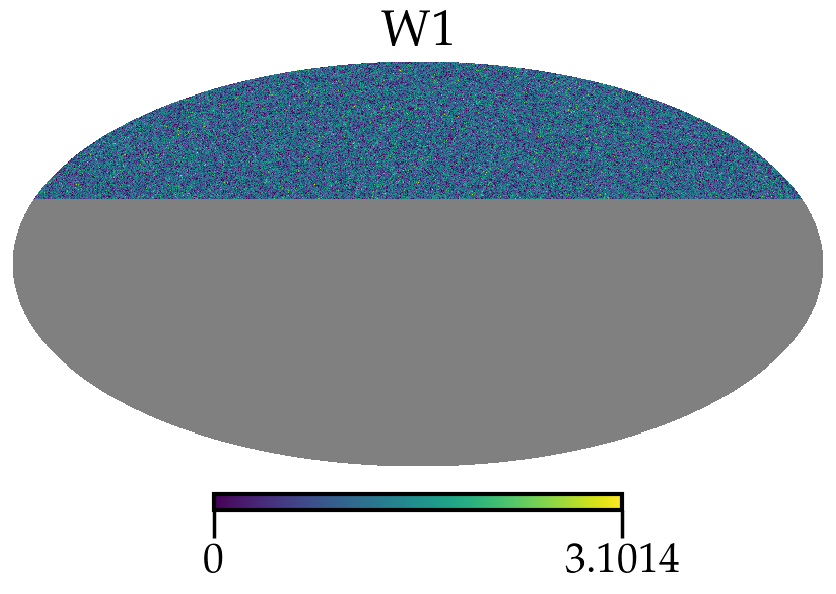

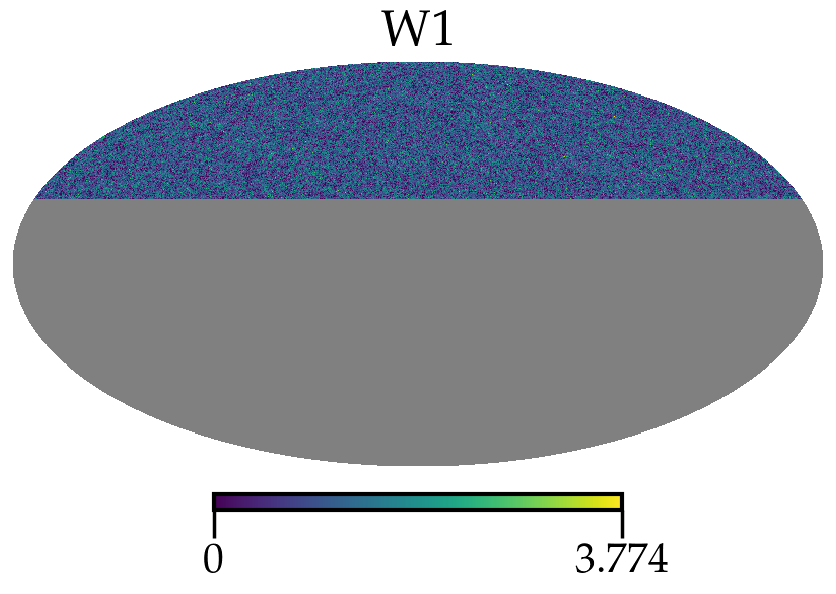

In [24]:
hp.mollview(zs_bin1[0]['window'],title='W1')
hp.mollview(zl_bin1[0]['window'],title='W1')
# hp.mollview(zs_bin1w[0]['window'],title='W2')
# hp.mollview(zl_bin1w[0]['window'],title='W2')
# hp.mollview(win_tt,title='window')

In [25]:
import window_utils
reload(window_utils)
from window_utils import *

import tracer_utils
reload(tracer_utils)
from tracer_utils import *


import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [26]:
client

<Client: scheduler='inproc://136.152.250.206/23077/1' processes=1 cores=10>

In [27]:
zs_bin1['SN']['galaxy']

array([[[2.78166788e-07]]])

In [28]:
if not use_shot_noise:
    for t in zs_bin1['SN'].keys():
        zs_bin1['SN'][t]*=0
#         zs_bin1w['SN'][t]*=0
#         zl_bin1w['SN'][t]*=0
        zl_bin1['SN'][t]*=0

In [29]:
corrs

[('shear', 'shear'), ('galaxy', 'shear'), ('galaxy', 'galaxy')]

In [30]:
import tracer_utils
reload(tracer_utils)
from tracer_utils import *
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [31]:
do_xi=False

In [32]:
kappa0=cov_3X2(zs_bins=copy.deepcopy(zs_bin1),do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()
else:
    %time cl0=clG0['stack'].compute()

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


{('shear', 'shear'): [(0, 0)], ('galaxy', 'galaxy'): [(0, 0)], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]} {'shear': 1, 'galaxy': 1, 'kappa': 0}
Win gen: step size 534
Window done
cl dict done
CPU times: user 8.78 s, sys: 476 ms, total: 9.26 s
Wall time: 4.53 s
CPU times: user 22.7 s, sys: 1.87 s, total: 24.6 s
Wall time: 4.34 s


In [35]:
pk_params_lin=copy.deepcopy(kappa0.Ang_PS.PS.pk_params)
pk_params_lin['non_linear']=0

In [38]:
kappa0_lin=cov_3X2(zs_bins=copy.deepcopy(zs_bin1),do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)
kappa0_lin.Ang_PS.PS.pk_params=pk_params_lin
%time clG0_lin=kappa0_lin.cl_tomo(corrs=corrs) 
if do_xi:
    %time xiG_L0_lin=kappa0_lin.xi_tomo()
    %time xi_L0_lin=xiG_L0_lin['stack'].compute()
else:
    %time cl0_lin=clG0_lin['stack'].compute()

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


{('shear', 'shear'): [(0, 0)], ('galaxy', 'galaxy'): [(0, 0)], ('shear', 'galaxy'): [(0, 0)], ('galaxy', 'shear'): [(0, 0)]} {'shear': 1, 'galaxy': 1, 'kappa': 0}
Win gen: step size 534
Window done
cl dict done
CPU times: user 7 s, sys: 78.3 ms, total: 7.08 s
Wall time: 2.46 s
CPU times: user 23 s, sys: 1.67 s, total: 24.7 s
Wall time: 4.36 s


In [40]:
clg0_t={}
clg0_lin_t={}
for corr in corrs:
    clg0_t[corr]=clG0['cl'][corr][(0,0)].compute()
    clg0_lin_t[corr]=clG0_lin['cl'][corr][(0,0)].compute()
clg0=(clg0_t[corr_gg],clg0_t[corr_ll],clg0_t[corr_ll]*0,clg0_t[corr_ggl])
clg0_lin=(clg0_lin_t[corr_gg],clg0_lin_t[corr_ll],clg0_lin_t[corr_ll]*0,clg0_lin_t[corr_ggl])

[]

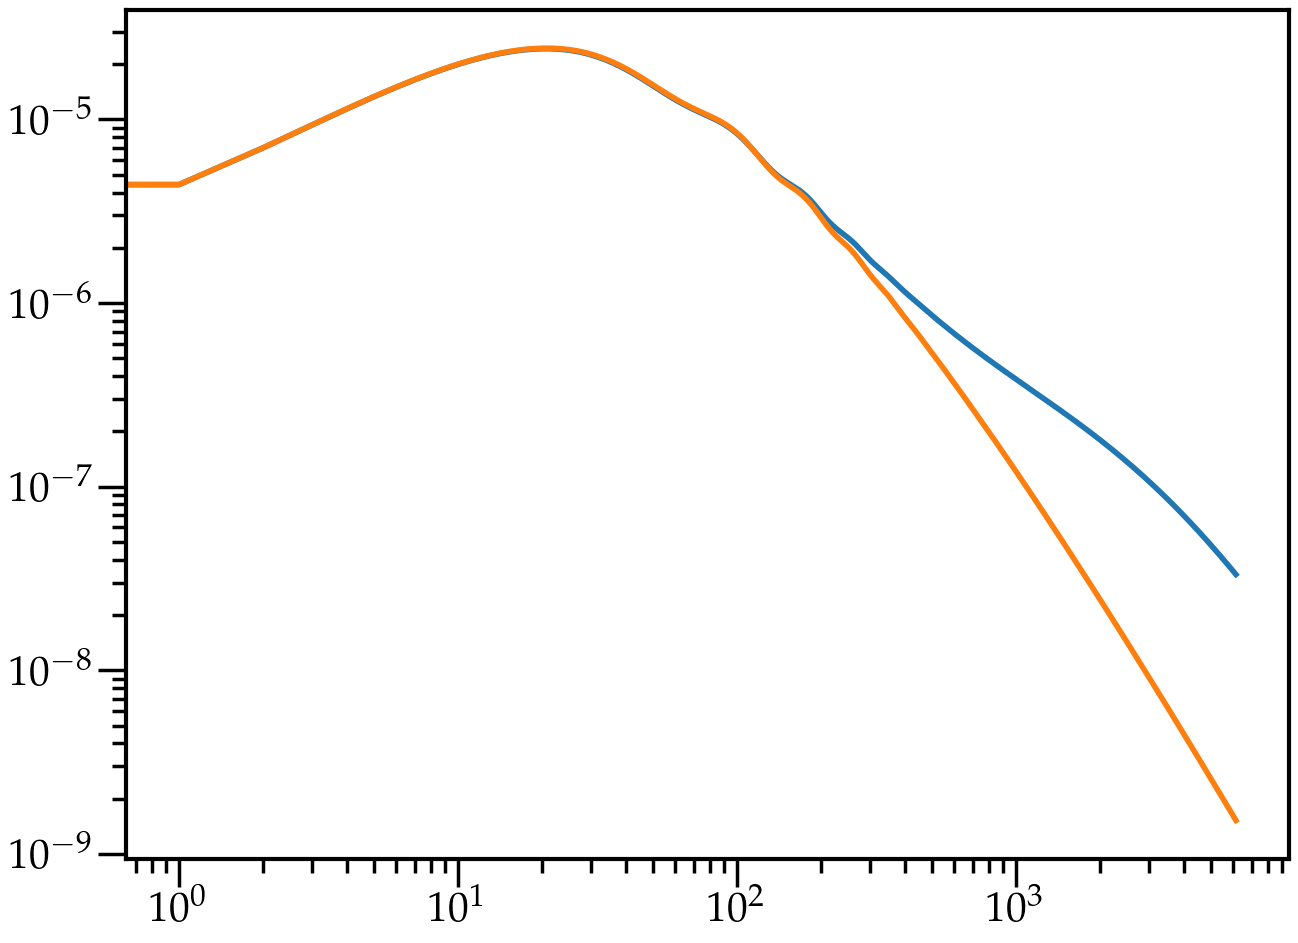

In [48]:
plot(l,clg0[0])
plot(l,clg0_lin[0])
loglog()

In [49]:
clg2=(np.log(1+clg0_t[corr_gg]),np.log(1+clg0_t[corr_ll]),clg0_t[corr_ll]*0,np.log(1+clg0_t[corr_ggl]))

In [50]:
# nside=1024
l_t=np.arange(nside*3-1+1)
gamma_trans_factor = np.array([np.sqrt( (li+2)*(li-1)/(li*(li+1))) for li in l_t   ] )
gamma_trans_factor[0] = 0.
gamma_trans_factor[1] = 0.
l_alm,m_alm=hp.sphtfunc.Alm.getlm(l_t.max())
l_alm=np.int32(l_alm)
m_alm=0
gamma_trans_factor=gamma_trans_factor[l_alm]
l_alm=0

def kappa_to_shear_map(kappa_map=[]):
    kappa_alm = hp.map2alm(kappa_map,pol=False)        
    gamma_alm = []
    gamma_alm=kappa_alm*gamma_trans_factor#[l_alm]
    k_map, g1_map, g2_map = hp.sphtfunc.alm2map( [kappa_alm,gamma_alm,kappa_alm*0 ], nside=nside,pol=True  )
    return g1_map,g2_map

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
cl_map0=hp.synfast(clg0,nside=nside,new=True,pol=False)
cl_map=hp.synfast(clg0_lin,nside=nside,new=True,pol=False)
cl_map_min=np.absolute(cl_map.min(axis=1))
scale_f=1
v0=np.std(cl_map.T/cl_map_min*scale_f,axis=0)
cl_map_l=np.exp(cl_map.T/cl_map_min*scale_f)*np.exp(-0.5*v0**2)-1
cl_map_l*=cl_map_min/scale_f
cl_map_l=cl_map_l.T
cl_map_l2=np.copy(cl_map_l)
# cl_tt=hp.anafast(cl_map_l[0],cl_map_l[1],lmax=lmax)
cl_map_l[1,:],cl_map_l[2,:]=kappa_to_shear_map(kappa_map=cl_map_l[1])
cl_map_mean=cl_map_l.mean(axis=1)
for i in np.arange(3):
    cl_map_l[i]-=cl_map_l[i].mean()

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


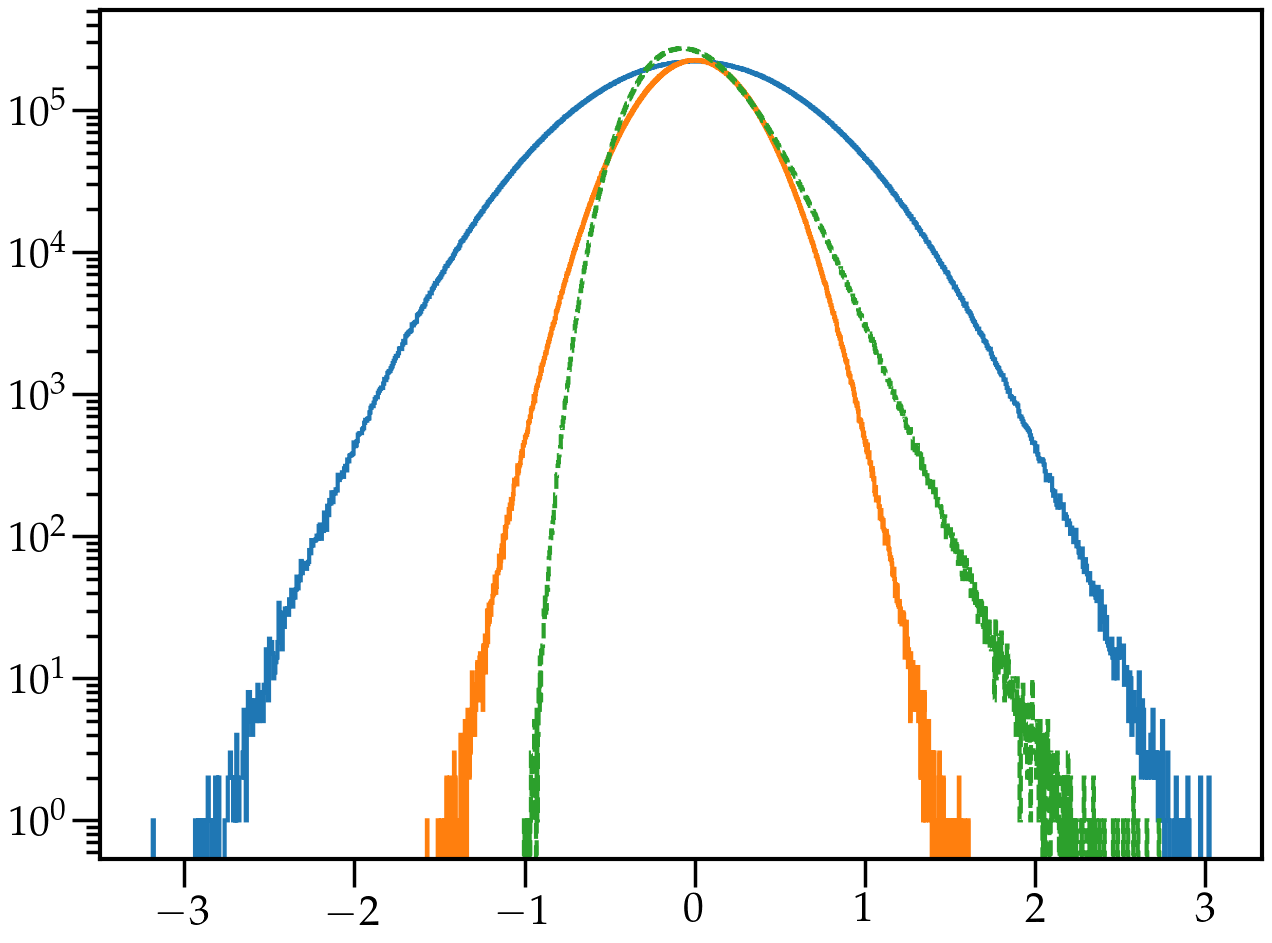

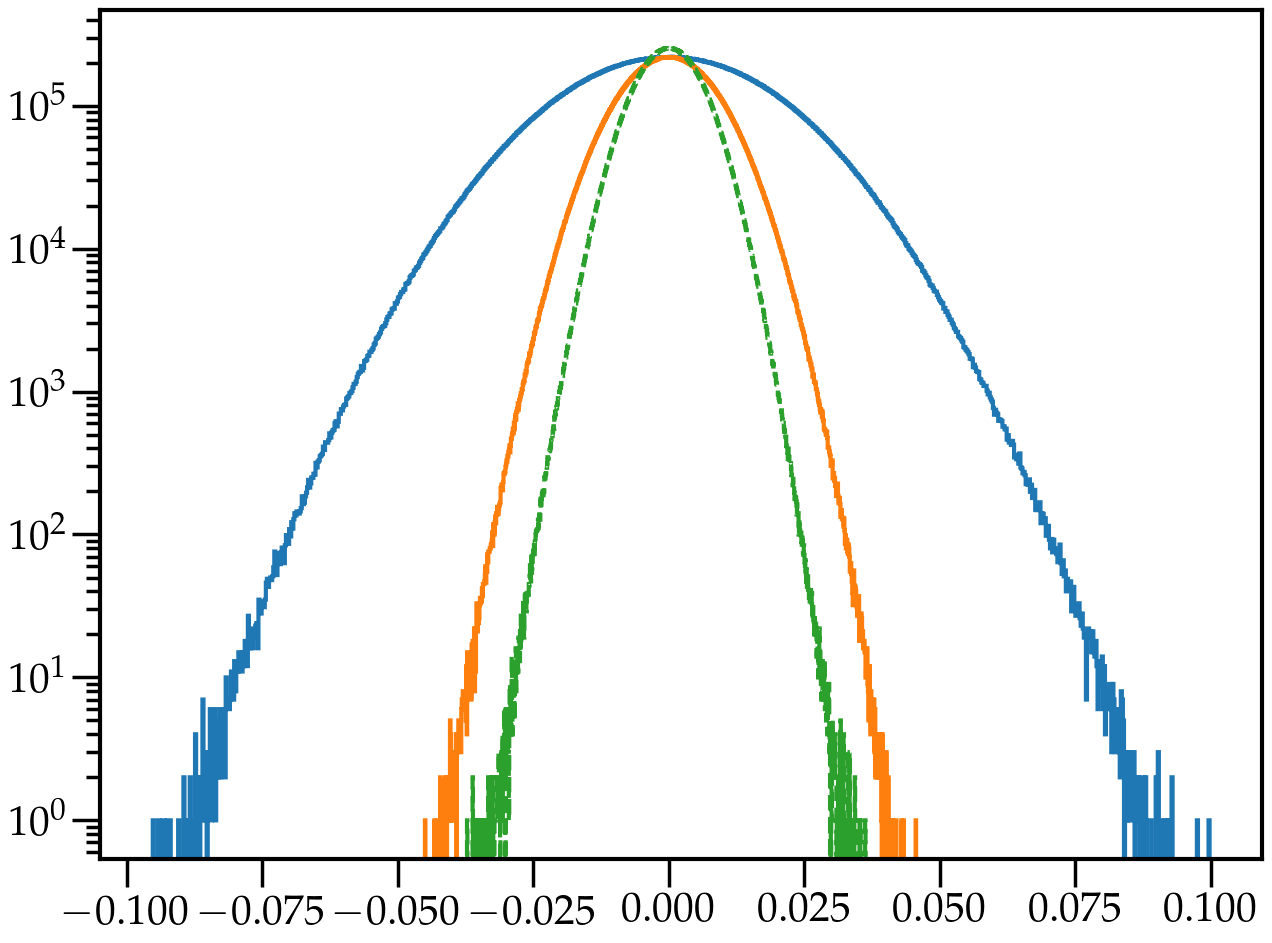

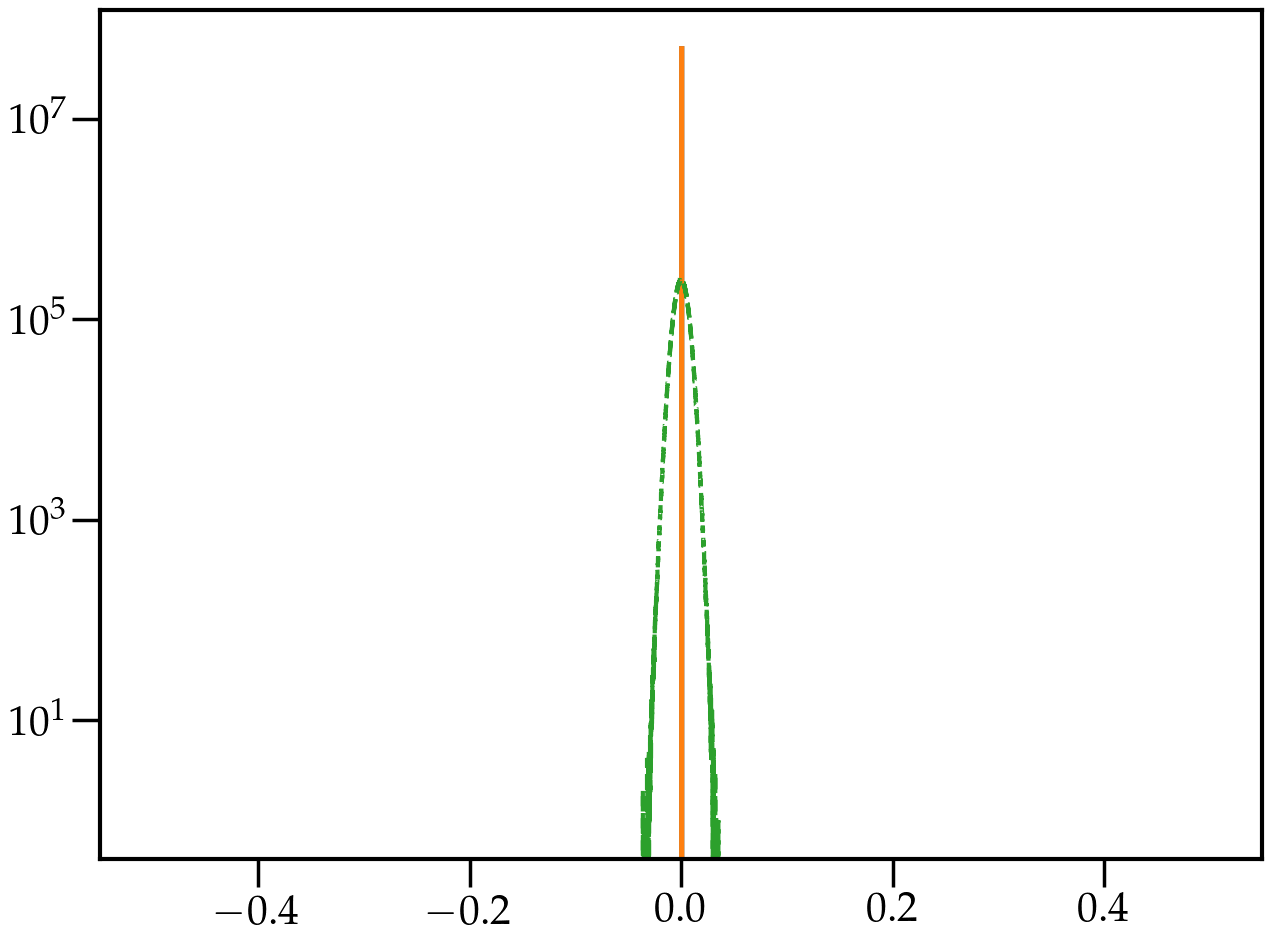

In [54]:
for i in np.arange(3):
    _=hist(cl_map0[i],1000,histtype='step')
    _=hist(cl_map[i],1000,histtype='step')
    _=hist(cl_map_l[i],1000,ls='--',histtype='step')
#     _=hist(cl_map_l2[i],1000,ls=':',histtype='step')
#     _=hist(np.exp(1+cl_map[i]),1000,histtype='step',ls=':')
    yscale('log')
    show()

In [55]:
i=0

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194

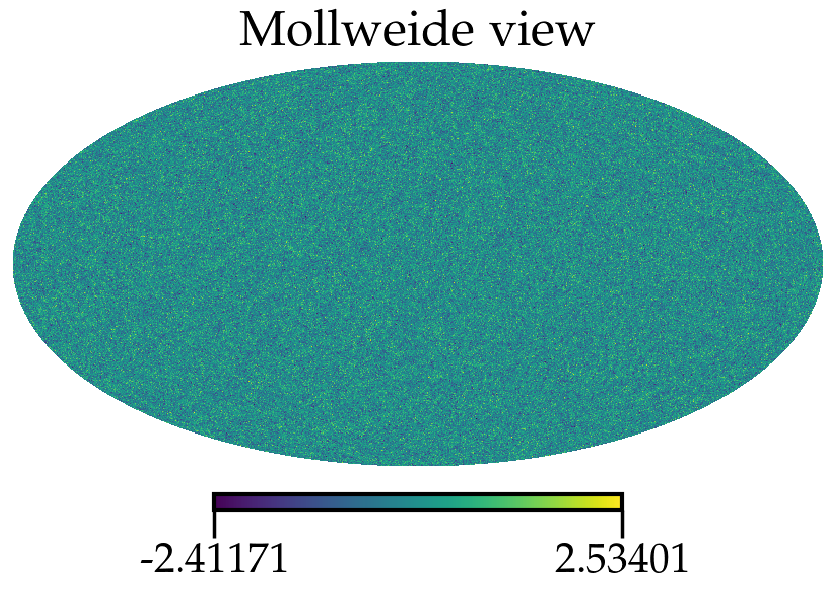

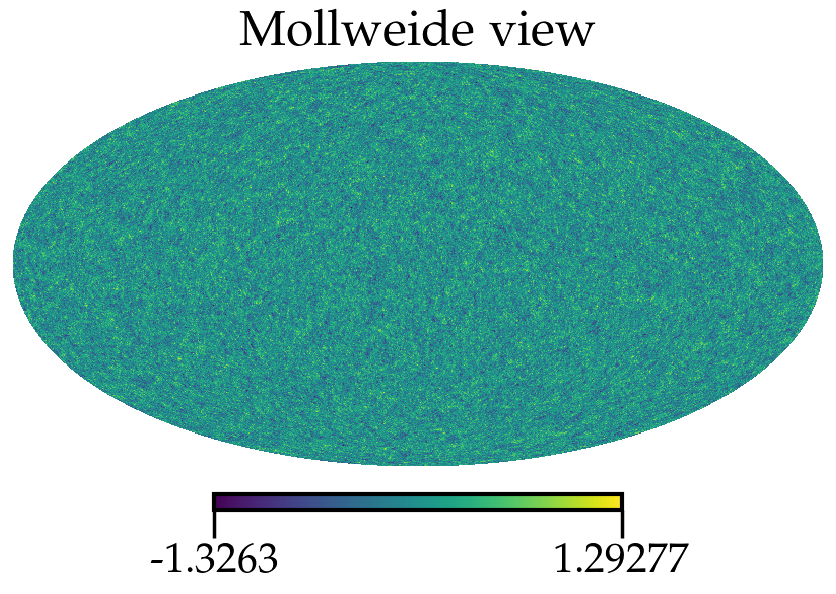

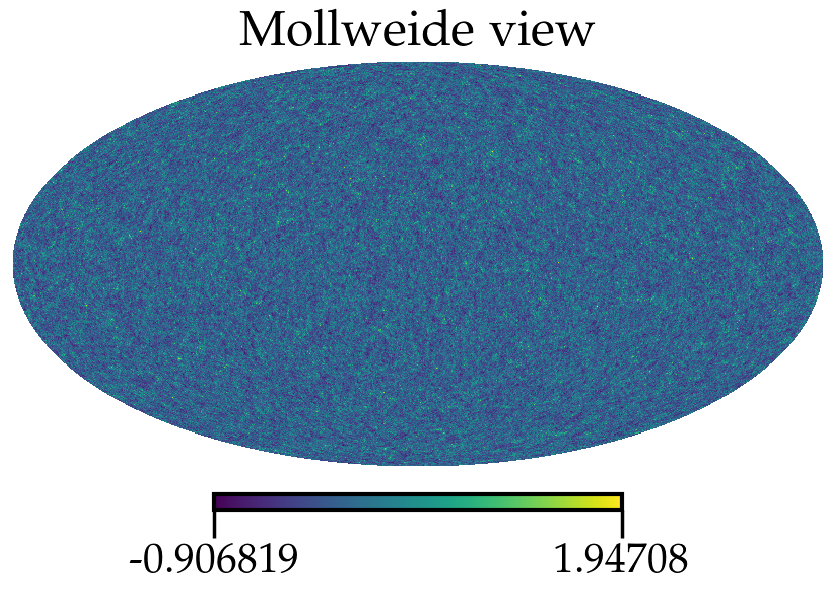

In [56]:
hp.mollview(cl_map0[i])
hp.mollview(cl_map[i])
hp.mollview(cl_map_l[i])

In [57]:
cl_t0=hp.anafast(cl_map0,pol=False,lmax=kappa0.l.max())
cl_t=hp.anafast(cl_map,pol=False,lmax=kappa0.l.max())
cl_t_l=hp.anafast(cl_map_l,pol=True,lmax=kappa0.l.max())
cl_t_l2=hp.anafast(cl_map_l2,pol=False,lmax=kappa0.l.max())

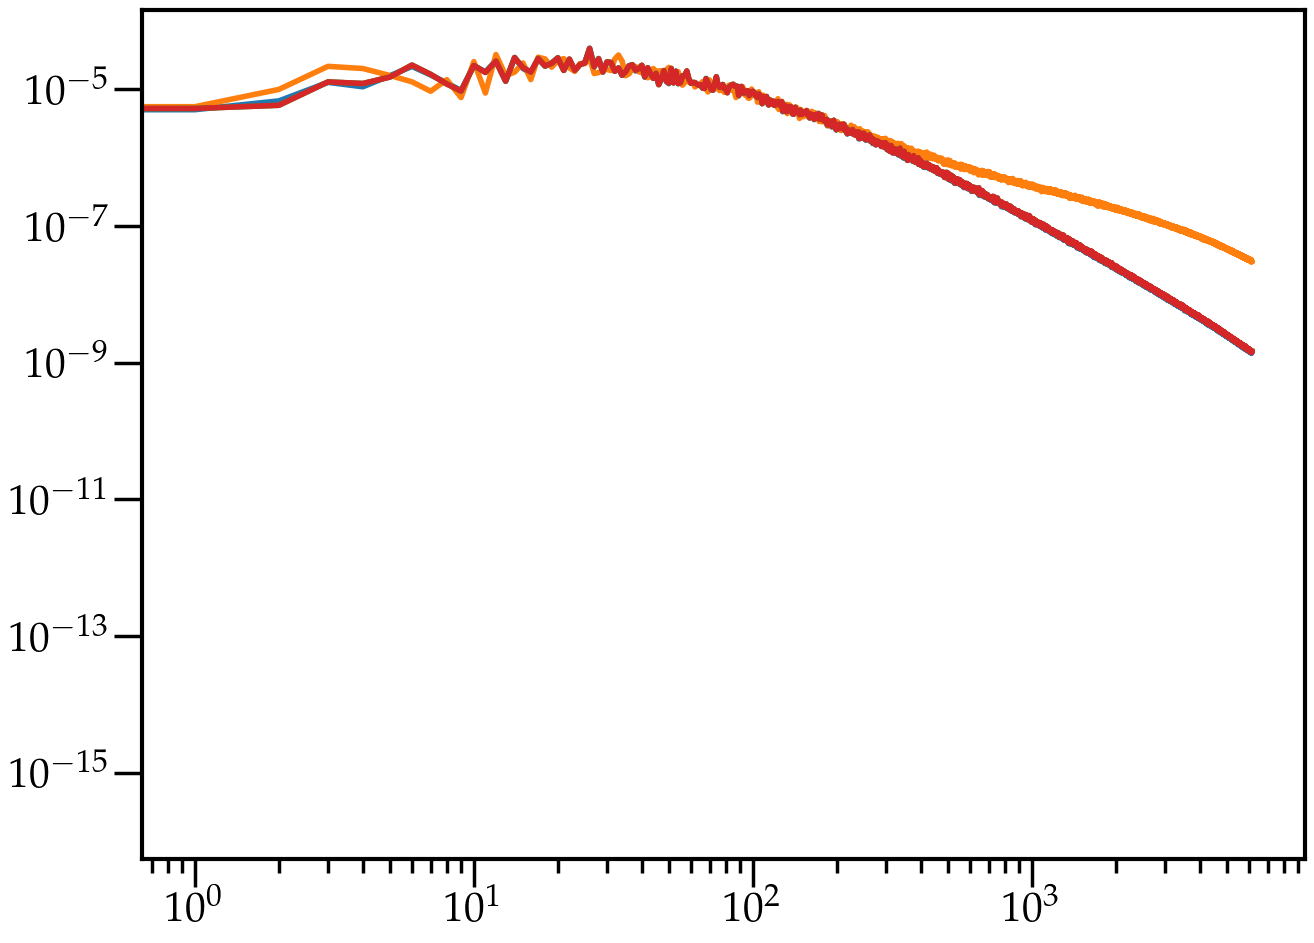

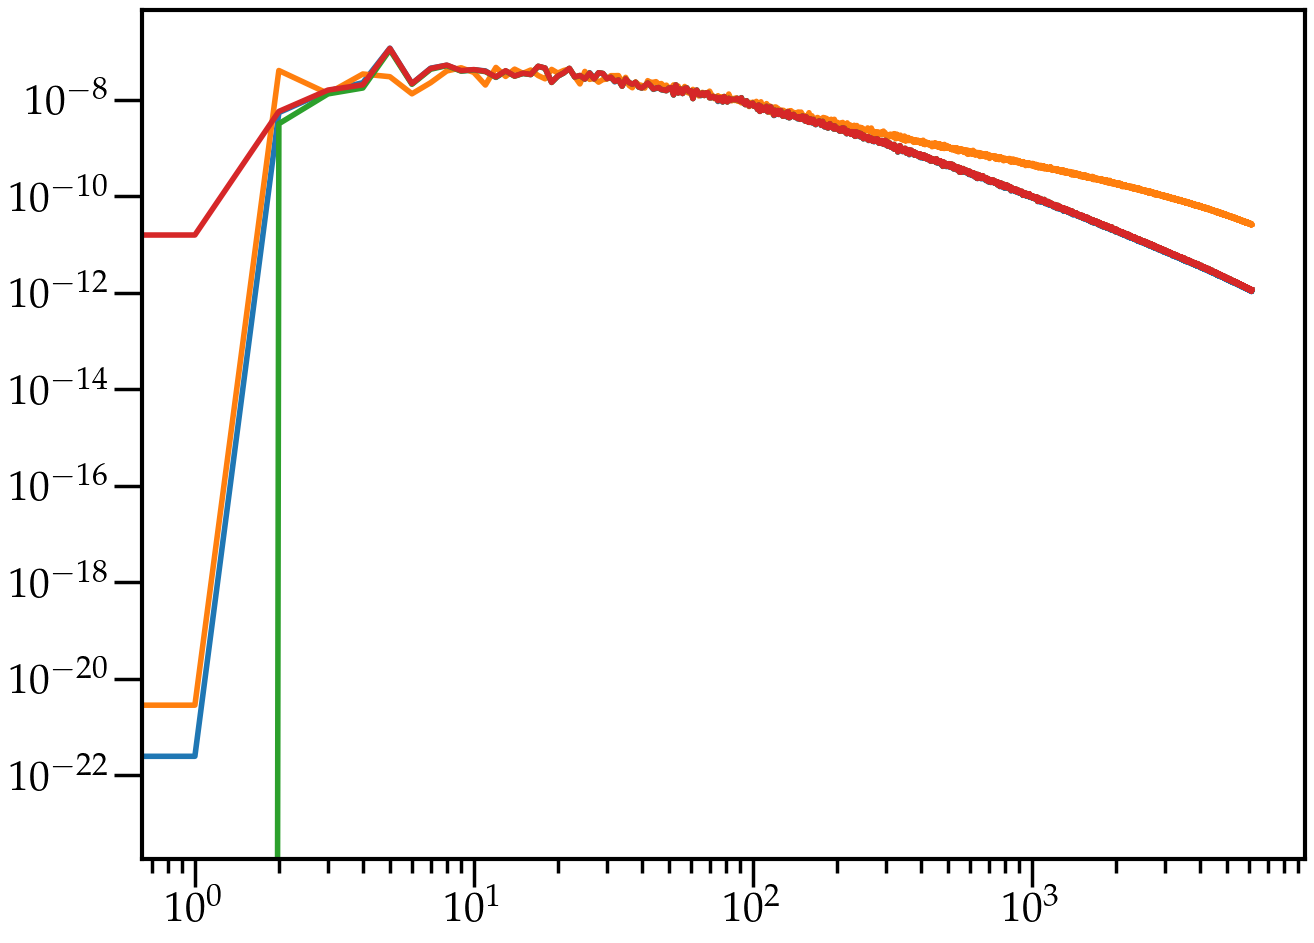

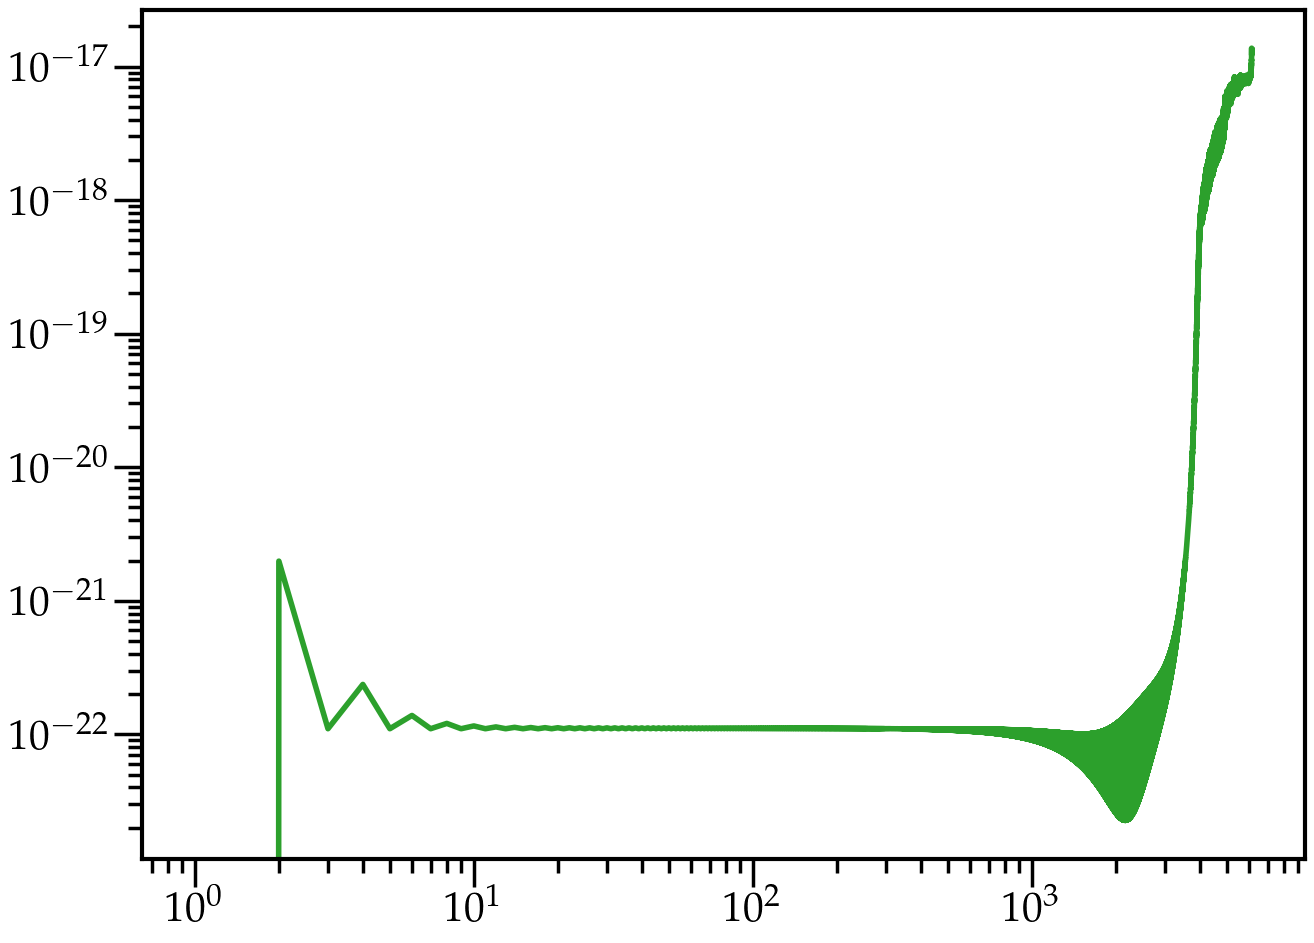

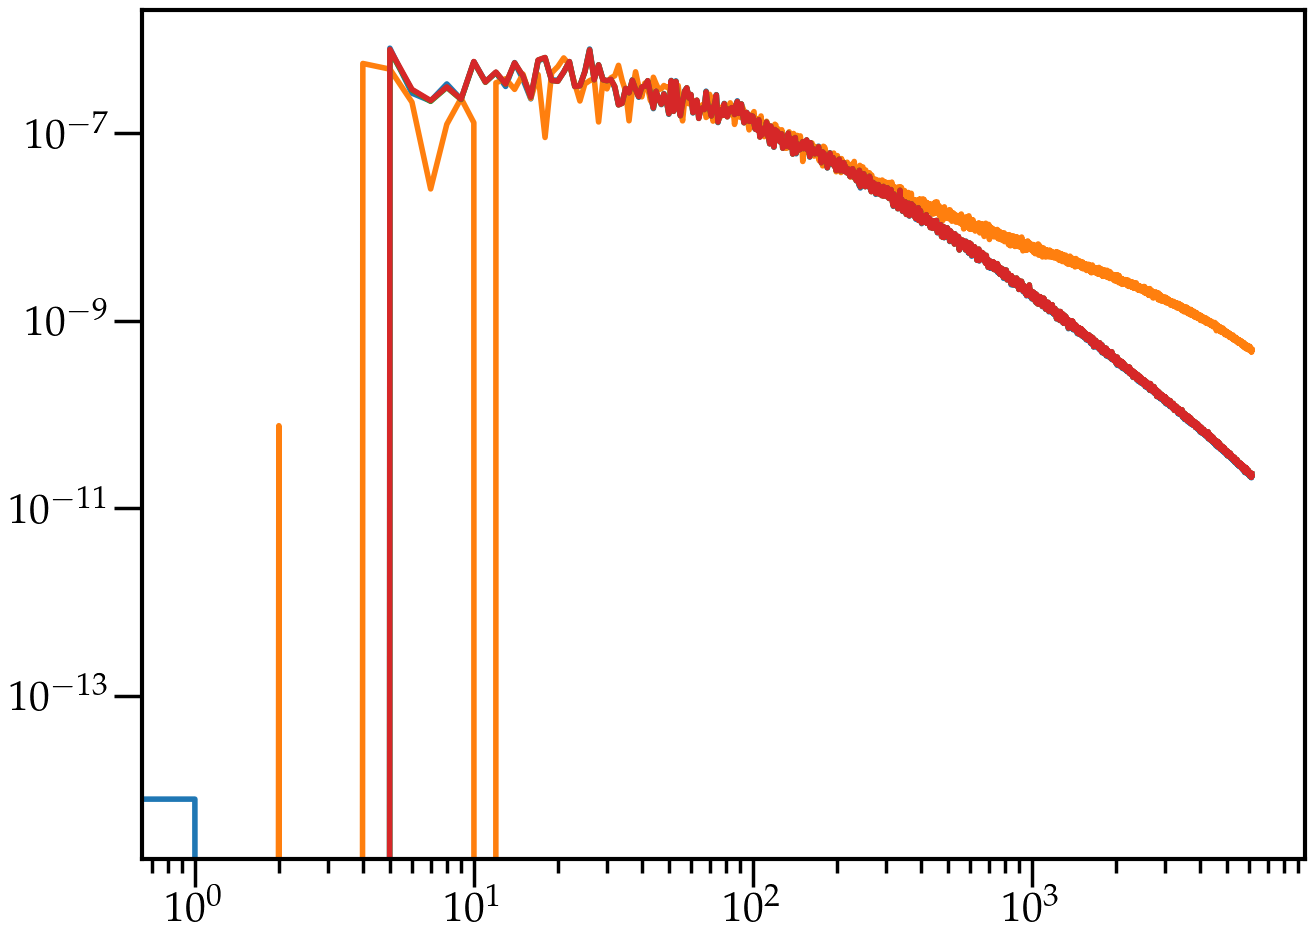

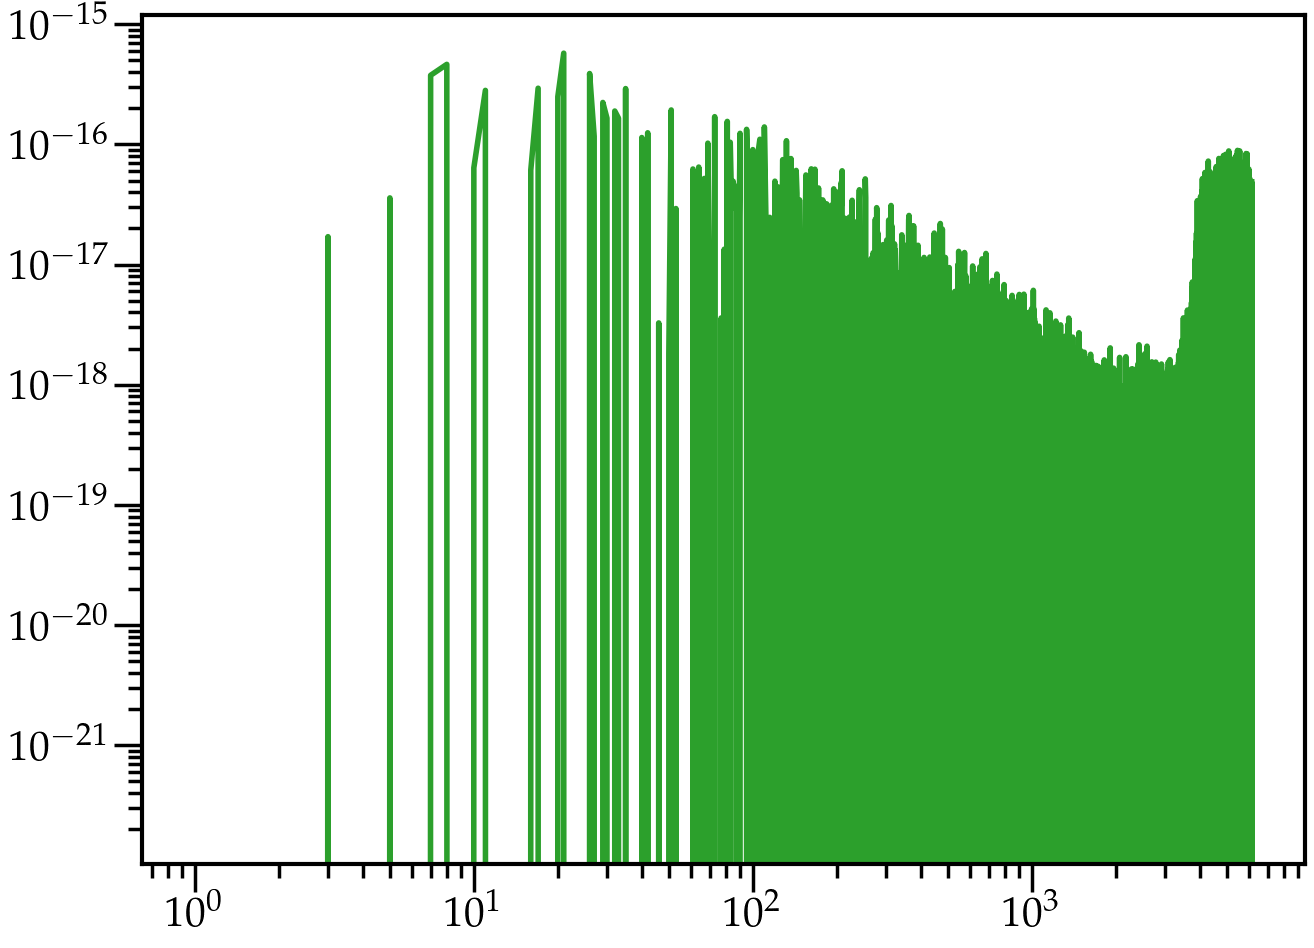

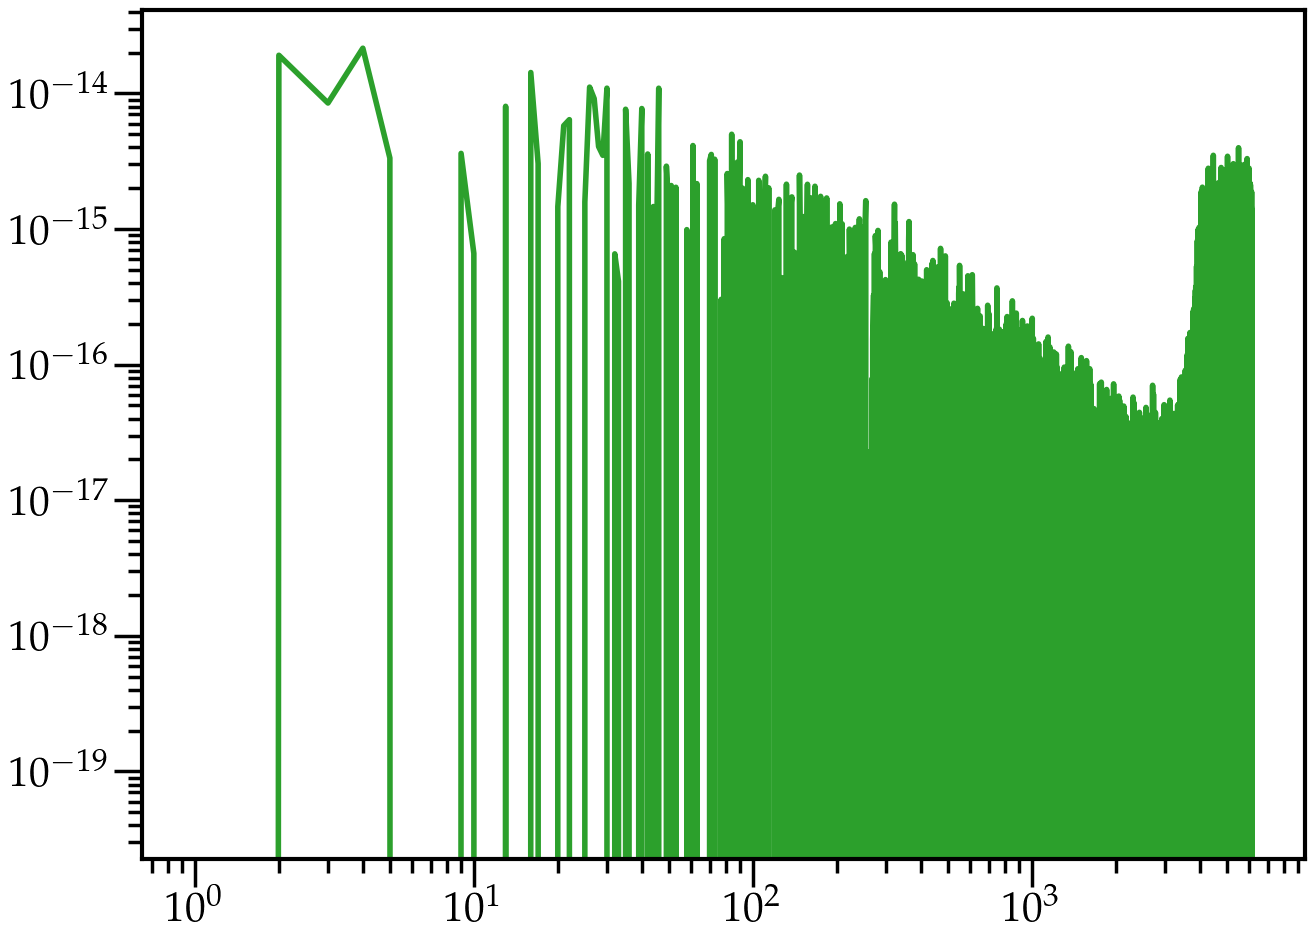

In [58]:
cl_t0_b=[]
cl_t_b=[]
cl_t_l_b=[]
cl_t_l2_b=[]
for i in np.arange(6):
    plot(cl_t[i])
    plot(cl_t0[i])
    plot(cl_t_l[i])
    plot(cl_t_l2[i])
    # plot(cl_t2)
    xscale('log')
    yscale('log')
    # ylim(0.9,1.0512)
    show()
    
    cl_t0_b.append(kappa0.binning.bin_1d(cl_t0[0],bin_utils=kappa0.cl_bin_utils))
    cl_t_b.append(kappa0.binning.bin_1d(cl_t[0],bin_utils=kappa0.cl_bin_utils))
    cl_t_l_b.append(kappa0.binning.bin_1d(cl_t_l[0],bin_utils=kappa0.cl_bin_utils))
    cl_t_l2_b.append(kappa0.binning.bin_1d(cl_t_l2[0],bin_utils=kappa0.cl_bin_utils))

In [59]:
cl_t[i]/cl_t_l[i]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([nan, nan,  0., ...,  0.,  0.,  0.])

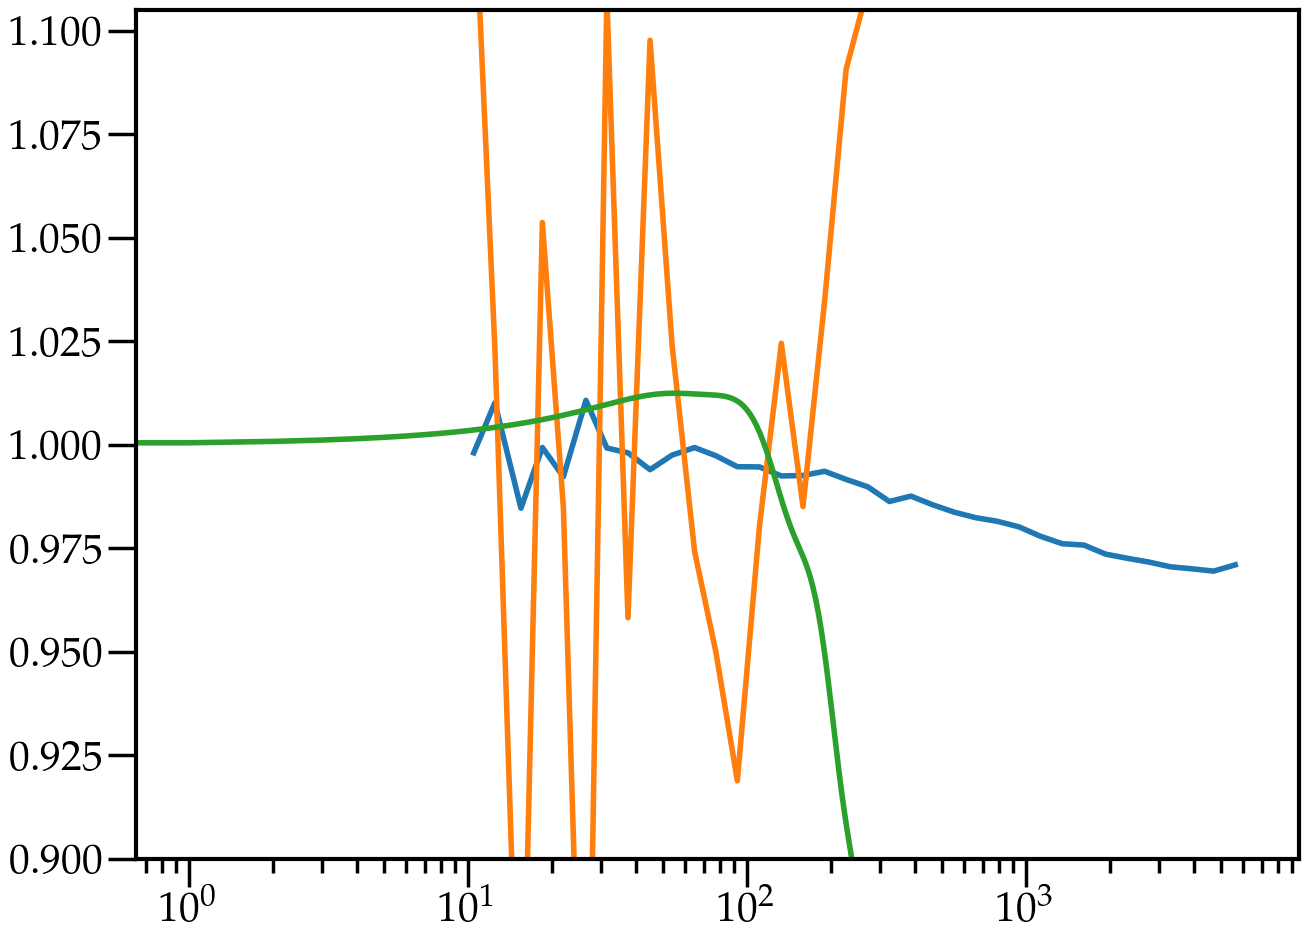

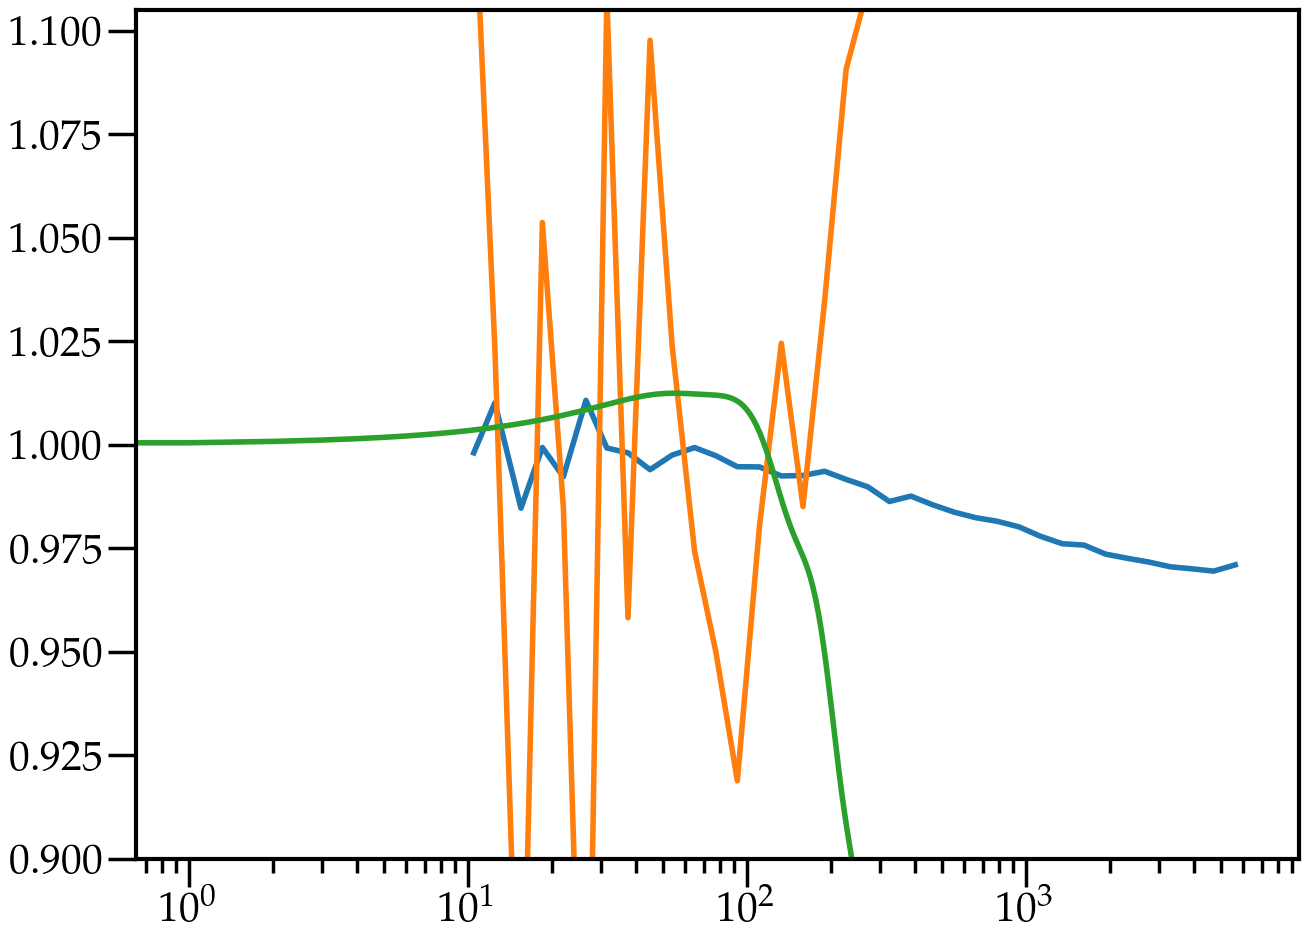

In [61]:
for i in np.arange(2):
    plot(lb,cl_t_b[i]/cl_t_l_b[i])
    plot(lb,cl_t0_b[i]/cl_t_l_b[i])
    plot(l,clg0_lin[0]/clg0[0])
    # plot(cl_t2)
    xscale('log')
    ylim(0.9,1.10512)
    show()

In [43]:
kappa0.binning.bin_1d(cl_t0[0],bin_utils=kappa0.cl_bin_utils)

array([2.06921817e-05, 2.35055853e-05, 2.10331188e-05, 1.92316945e-05,
       2.47451890e-05, 2.64095515e-05, 2.27195950e-05, 1.81418512e-05,
       1.67257488e-05, 1.41811494e-05, 1.19792124e-05, 1.13175269e-05,
       9.32332828e-06, 7.13692339e-06, 5.31982867e-06, 4.32629535e-06,
       3.47170031e-06, 2.53932734e-06, 2.02557750e-06, 1.54726877e-06,
       1.21077147e-06, 9.36549349e-07, 7.50327092e-07, 6.10872182e-07,
       4.99114569e-07, 4.09805138e-07, 3.37944682e-07, 2.79678368e-07,
       2.29190270e-07, 1.87848118e-07, 1.51029699e-07, 1.19555515e-07,
       9.32645378e-08, 7.11160860e-08, 5.21824568e-08, 3.68025676e-08])

In [44]:
cl_alm=hp.synalm(clg0[0],lmax=nside*3-1,new=True)

In [45]:
cl_map=hp.synfast(clg0[0],nside=nside)
cl_map_min=np.absolute(cl_map.min())
scale_f=1
v0=np.std(cl_map.T/cl_map_min*scale_f,axis=0)
cl_map_l=np.exp(cl_map.T/cl_map_min*scale_f)*np.exp(-0.5*v0**2)-1
cl_map_l*=cl_map_min/scale_f
cl_map_l=cl_map_l.T
cl_alm=hp.map2alm(cl_map_l)

/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [46]:
N=1.e-6/3.
N_map=hp.synfast(np.ones_like(clg0[0])*N,nside=nside)
m,dm,dm2=hp.sphtfunc.alm2map_der1(cl_alm, nside, lmax=None, mmax=None)
# m_l=np.exp(m)
m=cl_map_l
th,phi=hp.pix2ang(nside,np.arange(12*nside**2))
deriv_m=dm+dm2#*np.sin(th)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [47]:
deriv_m_smooth=hp.sphtfunc.smoothing(deriv_m, fwhm=15./60*np.pi/180.,)
m_smooth=hp.sphtfunc.smoothing(m, fwhm=5./60*np.pi/180.,)
m_smooth2=hp.sphtfunc.smoothing(m+N_map, fwhm=5./60*np.pi/180.,)

Sigma is 6.369914 arcmin (0.001853 rad) 
-> fwhm is 15.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [48]:
mask=np.absolute(deriv_m)<deriv_m.max()*0.01
m2=np.copy(m)
m2[~mask]=hp.UNSEEN

In [49]:
i_neigh=hp.pixelfunc.get_all_neighbours(nside, np.arange(12*nside**2))
m_neigh=m_smooth[i_neigh]
x_neigh=m_smooth>m_neigh
mask3=np.all(x_neigh,axis=0)+np.all(~x_neigh,axis=0)
m3=np.copy(m_smooth)
m3[~mask3]=hp.UNSEEN

In [50]:
m_neigh=None


In [51]:
# i_neigh=hp.pixelfunc.get_all_neighbours(nside, np.arange(12*nside**2))
m_neigh=m_smooth[i_neigh]
x_neigh=m_smooth>m_neigh
mask3=np.all(x_neigh,axis=0)+np.all(~x_neigh,axis=0)
m3=np.copy(m_smooth)
m3[~mask3]=hp.UNSEEN
deriv2=deriv_m.copy()
deriv2[~mask3]=hp.UNSEEN

In [52]:
# i_neigh=hp.pixelfunc.get_all_neighbours(nside, np.arange(12*nside**2))
m_neigh=m_smooth2[i_neigh]
x_neigh=m_smooth2>m_neigh
mask4=np.all(x_neigh,axis=0)+np.all(~x_neigh,axis=0)
m4=np.copy(m_smooth2)
m4[~mask4]=hp.UNSEEN
m5=np.copy(m_smooth)
m5[~mask4]=hp.UNSEEN

In [53]:
np.any(mask),mask.mean(),mask3.mean(),mask4.mean()

(True, 0.054710050423940025, 0.03789989153544108, 0.04731388886769613)

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


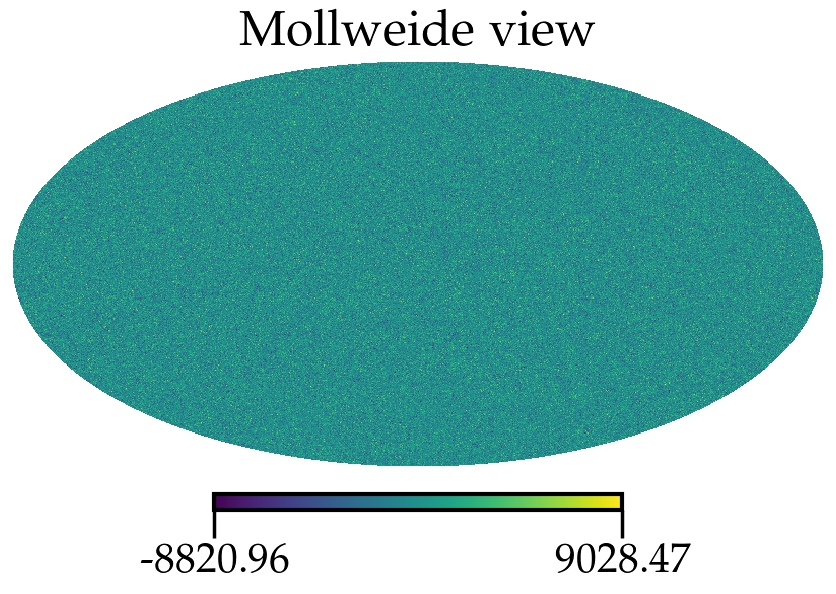

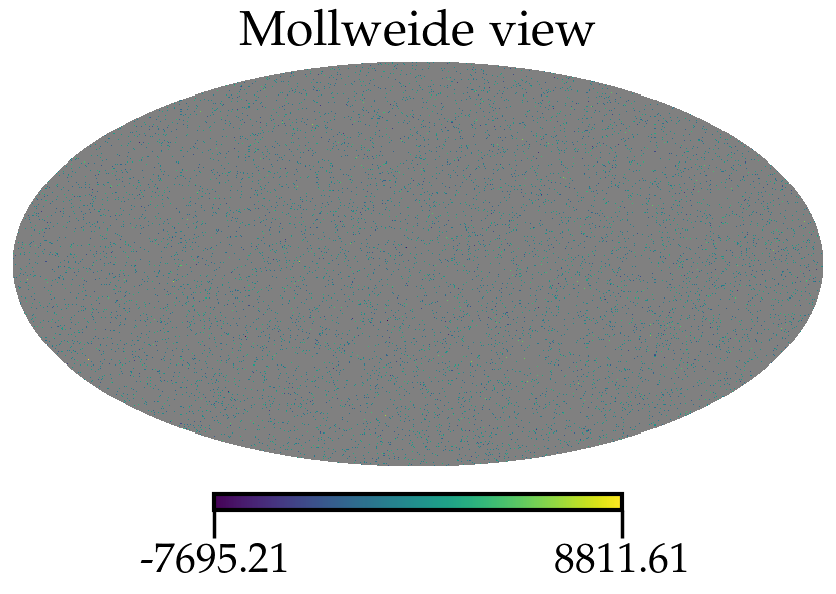

In [54]:
hp.mollview(deriv_m)
hp.mollview(deriv2)

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153

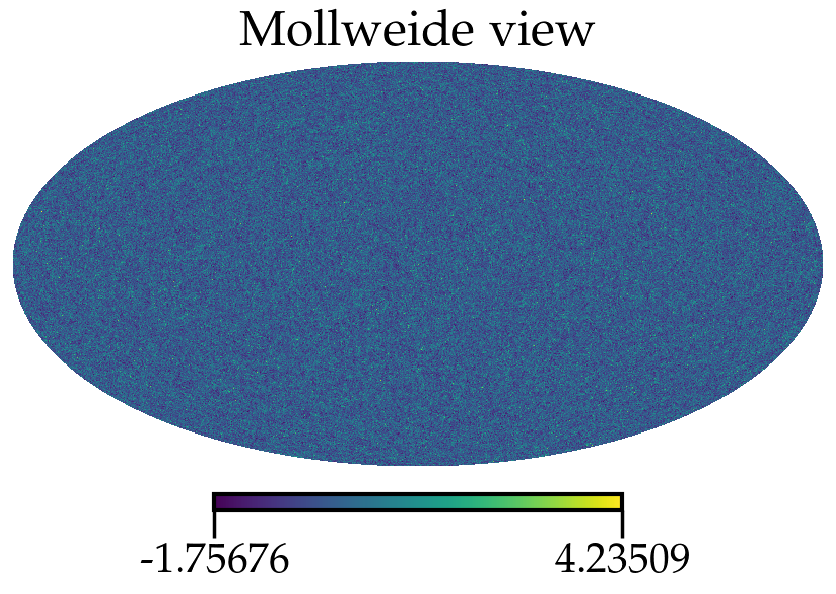

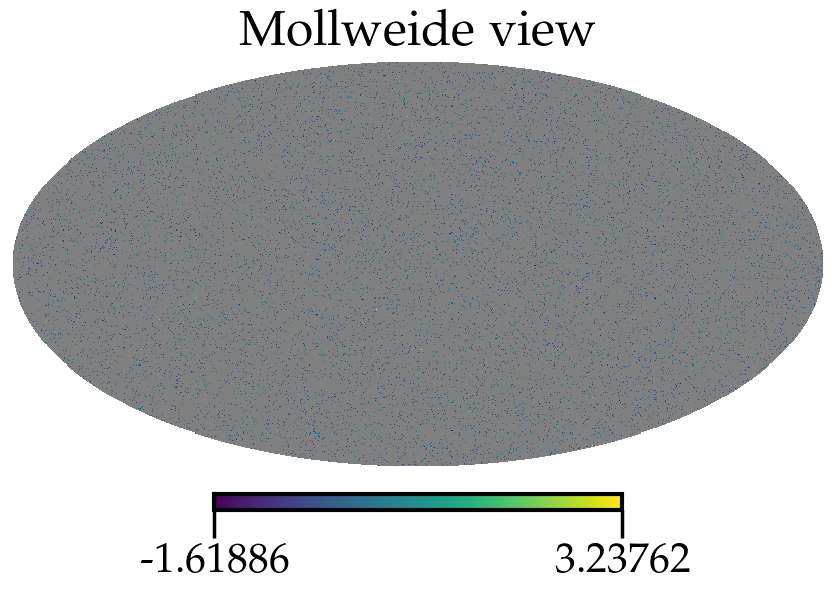

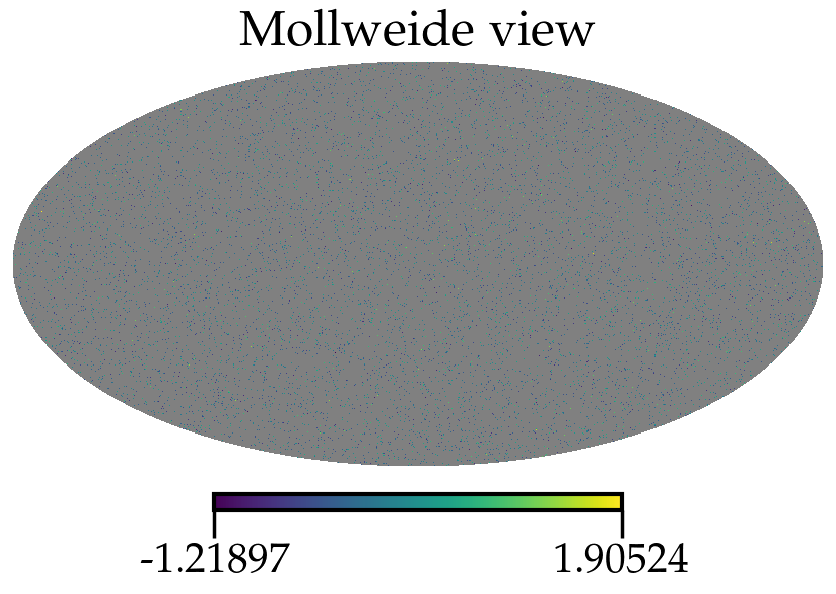

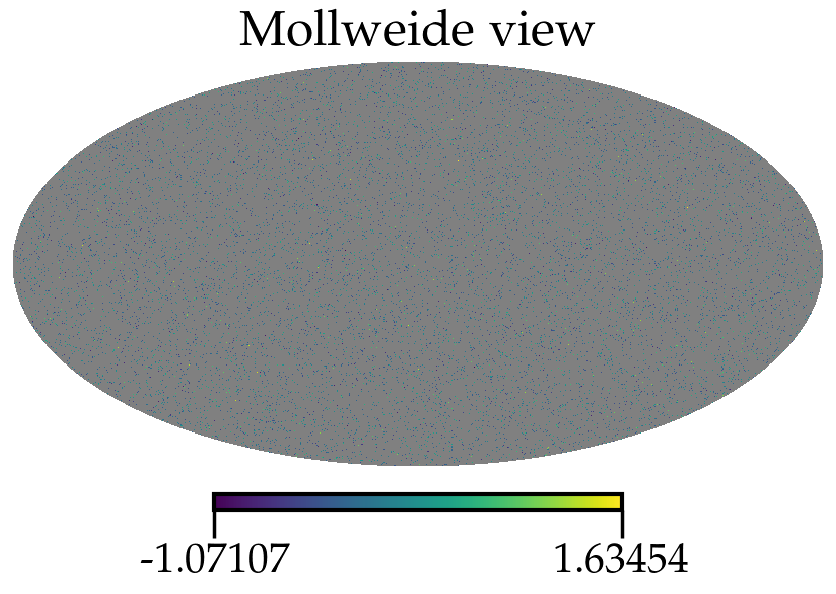

In [55]:
hp.mollview(m)
hp.mollview(m2)
hp.mollview(m3)
hp.mollview(m5)

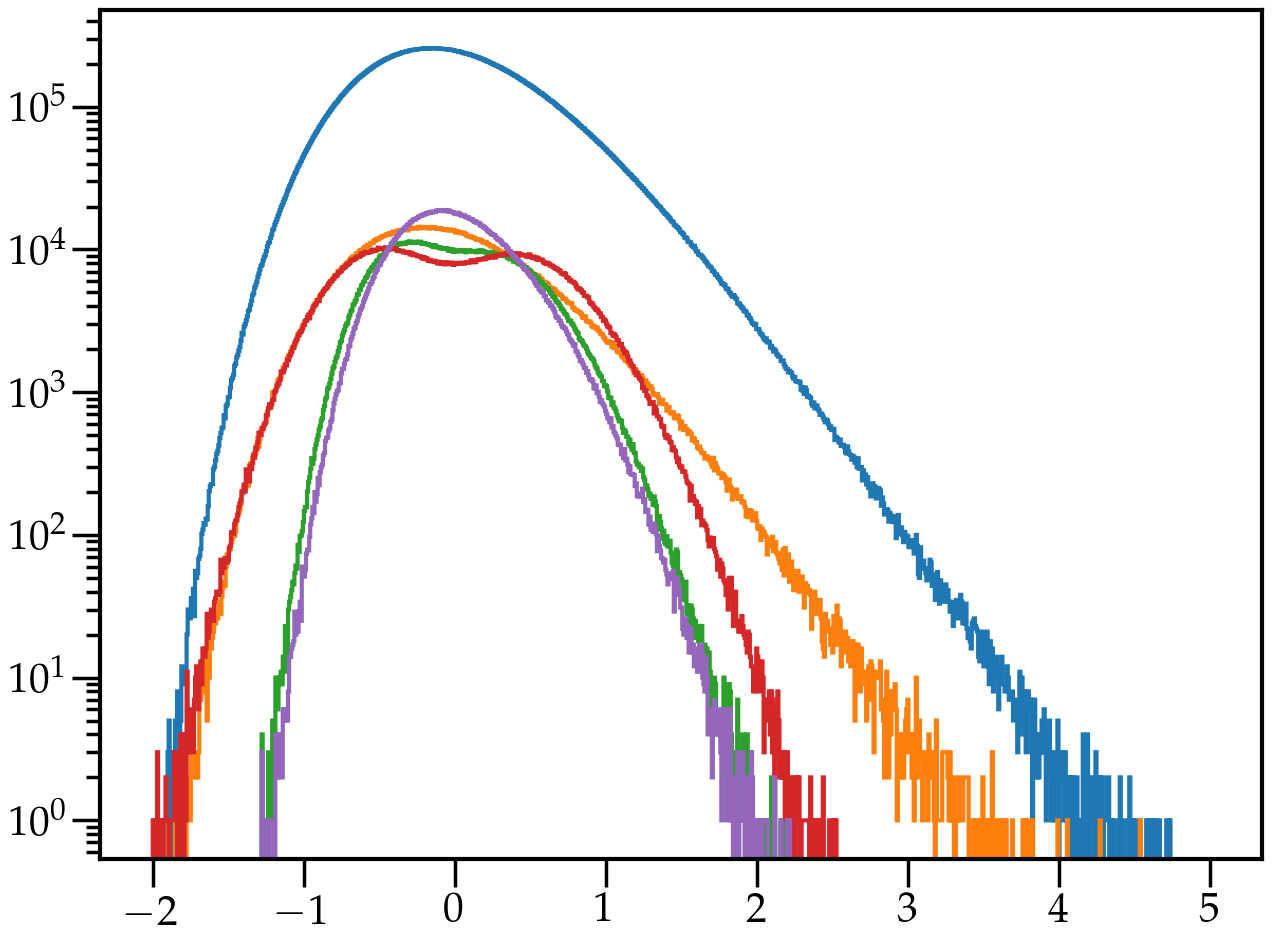

In [56]:
_=hist(m,1000,histtype='step',range=(-2,5))
_=hist(m2,1000,histtype='step',range=(-2,5))
_=hist(m3,1000,histtype='step',range=(-2,5))
_=hist(m4,1000,histtype='step',range=(-2,5))
_=hist(m5,1000,histtype='step',range=(-2,5))
yscale('log')
show()

In [62]:
cl_m=hp.anafast(m,pol=False,lmax=kappa0.l.max())
cl_m2=hp.anafast(m2,pol=False,lmax=kappa0.l.max())/mask.mean()
cl_m3=hp.anafast(m3,pol=False,lmax=kappa0.l.max())/mask3.mean()
cl_m4=hp.anafast(m4,pol=False,lmax=kappa0.l.max())/mask4.mean()
cl_m23=hp.anafast(m2,m3,pol=False,lmax=kappa0.l.max())/(mask3*mask).mean()
cl_m34=hp.anafast(m4,m3,pol=False,lmax=kappa0.l.max())/(mask3*mask4).mean()
cl_m5=hp.anafast(m5,pol=False,lmax=kappa0.l.max())/mask4.mean()
cl_m03=hp.anafast(m,m3,pol=False,lmax=kappa0.l.max())/(mask3).mean()
cl_m35=hp.anafast(m5,m3,pol=False,lmax=kappa0.l.max())/(mask3*mask4).mean()

In [68]:
mask3.mean(),(mask3*mask4).mean()

(0.03789989153544108, 0.005211452643076579)

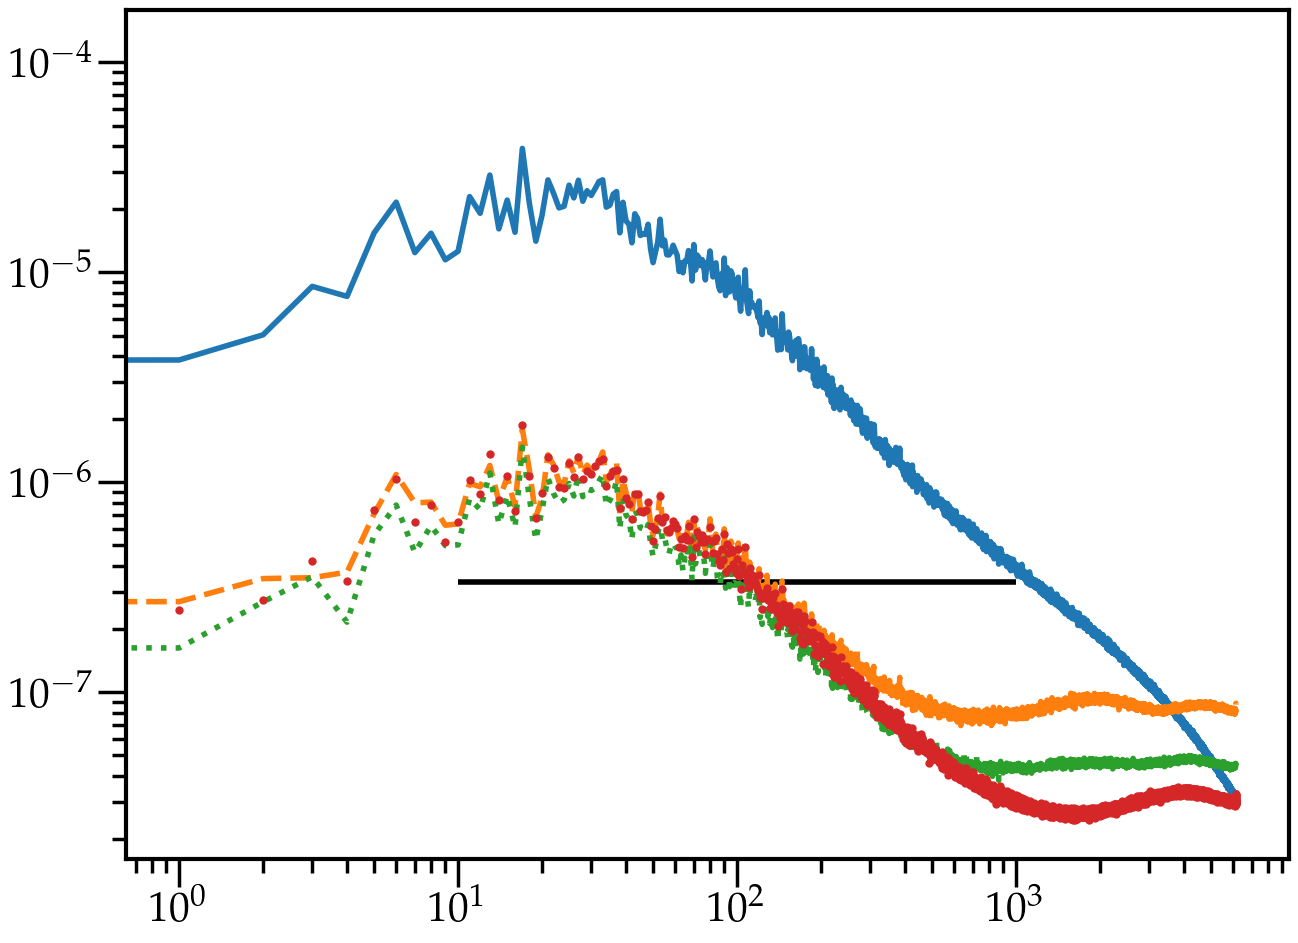

In [63]:
cl_m_b=[]
cl_m2_b=[]
cl_m3_b=[]
cl_m4_b=[]
cl_m5_b=[]
cl_m34_b=[]
cl_m35_b=[]
cl_m03_b=[]
for i in np.arange(1):
    plot(cl_m)
#     plot(cl_m2,'--')
    plot(cl_m4,'--')
    plot(cl_m3,':')
#     plot(cl_m23,':')
    plot(cl_m5,'.')
    xscale('log')
    yscale('log')
    # ylim(0.9,1.0512)
    hlines(N,10,1000)
    show()
    
    cl_m_b.append(kappa0.binning.bin_1d(cl_m,bin_utils=kappa0.cl_bin_utils))
    cl_m2_b.append(kappa0.binning.bin_1d(cl_m2,bin_utils=kappa0.cl_bin_utils))
    cl_m3_b.append(kappa0.binning.bin_1d(cl_m3,bin_utils=kappa0.cl_bin_utils))
    cl_m4_b.append(kappa0.binning.bin_1d(cl_m4,bin_utils=kappa0.cl_bin_utils))
    cl_m5_b.append(kappa0.binning.bin_1d(cl_m5,bin_utils=kappa0.cl_bin_utils))
    cl_m34_b.append(kappa0.binning.bin_1d(cl_m34,bin_utils=kappa0.cl_bin_utils))
    cl_m35_b.append(kappa0.binning.bin_1d(cl_m35,bin_utils=kappa0.cl_bin_utils))
    cl_m03_b.append(kappa0.binning.bin_1d(cl_m03,bin_utils=kappa0.cl_bin_utils))

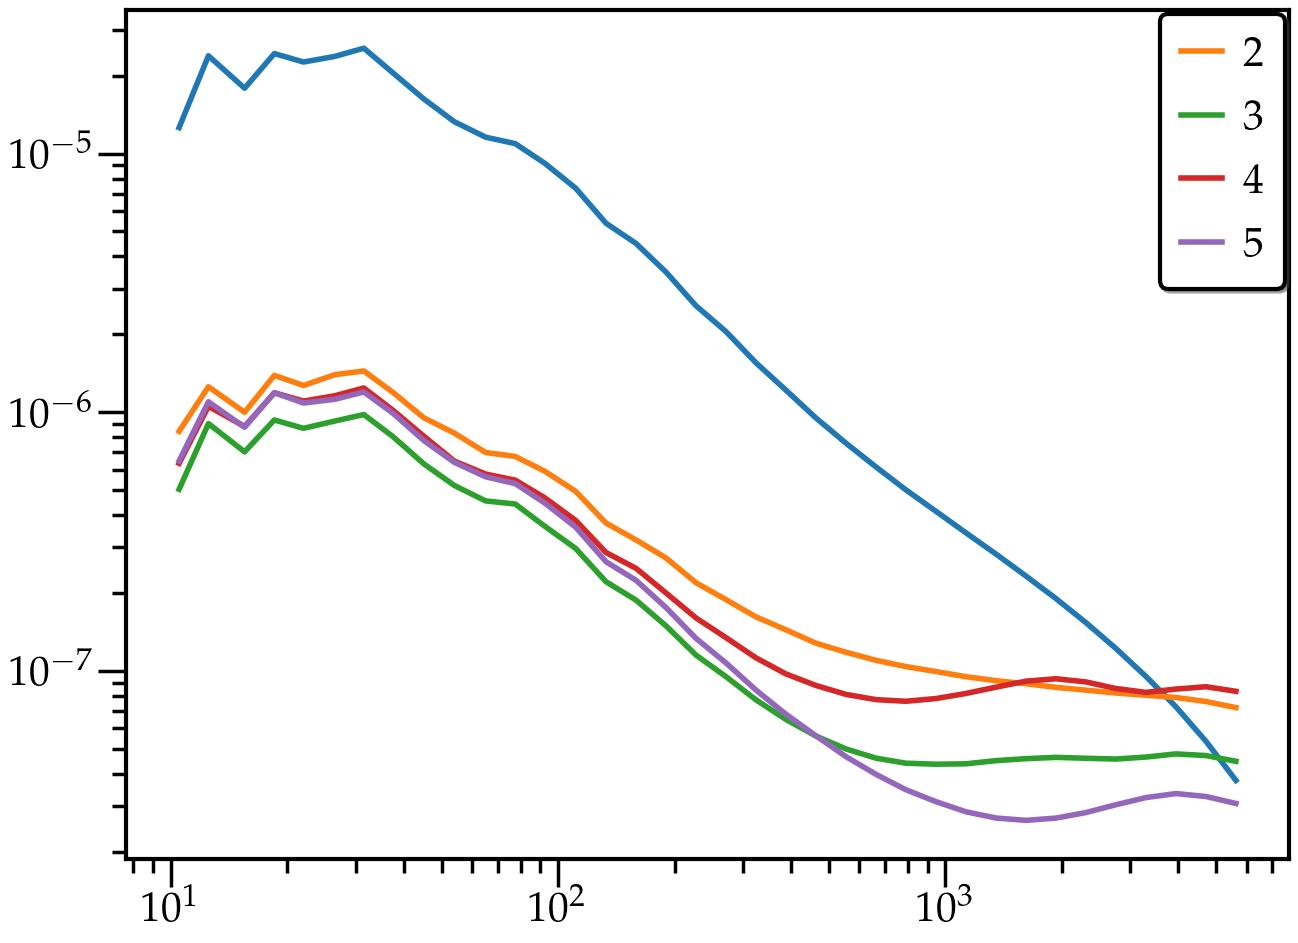

In [64]:
plot(lb,cl_m_b[0])
plot(lb,cl_m2_b[0],label='2')
plot(lb,cl_m3_b[0],label='3')
plot(lb,cl_m4_b[0],label='4')
plot(lb,cl_m5_b[0],label='5')
loglog()
legend()

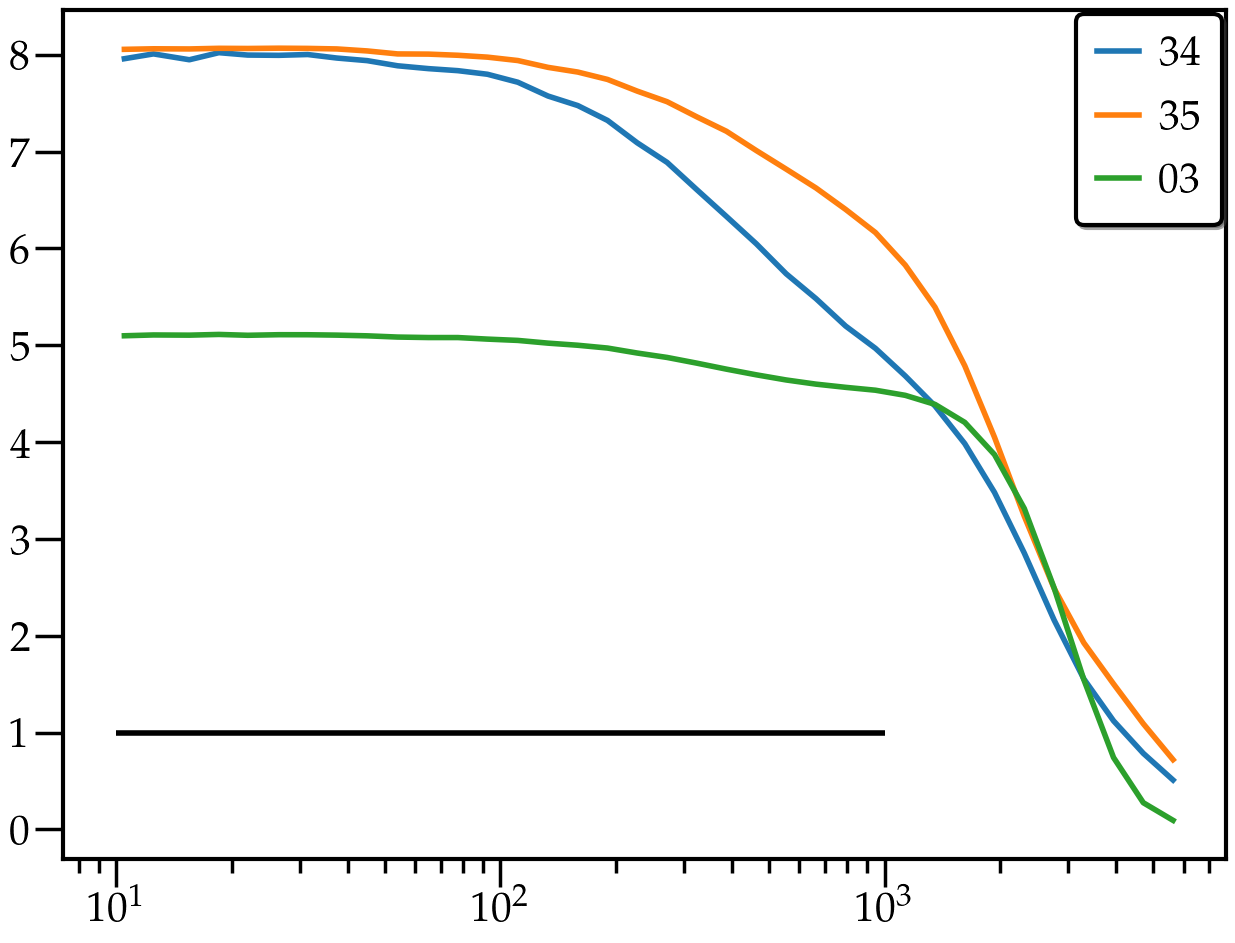

In [65]:
plot(lb,cl_m34_b[0]/np.sqrt(cl_m4_b[0]*cl_m3_b[0]),label='34')
plot(lb,cl_m35_b[0]/np.sqrt(cl_m5_b[0]*cl_m3_b[0]),label='35')
plot(lb,cl_m03_b[0]/np.sqrt(cl_m_b[0]*cl_m3_b[0]),label='03')
xscale('log')
hlines(1,10,1000)
legend()